<a href="https://colab.research.google.com/github/j0rd1smit/CS4245_cv_project_zebra_fish/blob/master/notebooks/colab/Detectron2_zebra_fish_segmatation-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2: Zebrafish

<table align="left">
<tbody><tr><td>
   <a target="_blank" href="https://colab.research.google.com/github/j0rd1smit/CS4245_cv_project_zebra_fish/blob/master/notebooks/colab/Detectron2_zebra_fish_segmatation-colab.ipynb">
     <img src="https://camo.githubusercontent.com/dfbf50eed8dd2dea5f3e0beaaf2001eeca77f314/68747470733a2f2f7777772e74656e736f72666c6f772e6f72672f696d616765732f636f6c61625f6c6f676f5f333270782e706e67" data-canonical-src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab
   </a>
 </td>
<td>
   <a target="_blank" href="https://github.com/j0rd1smit/CS4245_cv_project_zebra_fish/blob/master/notebooks/colab/Detectron2_zebra_fish_segmatation-colab.ipynb">
     <img width="32px" src="https://camo.githubusercontent.com/9a6bfd119aeed95f13553a994f2d1cd97e033768/68747470733a2f2f7777772e74656e736f72666c6f772e6f72672f696d616765732f4769744875622d4d61726b2d333270782e706e67" data-canonical-src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a>
 </td>
</tr></tbody></table>

## Install detectron2

In [1]:
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 26kB/s 
     |████████████████████████████████| 4.1MB 12.3MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 276kB 4.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=436d22924657b3a6af1696f9882763d33c7f366c53a714a5634dff72570cbce9
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [2]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 5.9MB 1.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200604-cp36-none-any.whl size=41027 sha256=d40281521b1db0300d0e90ef8e5edad71faa5cbf7c9a67530dc059fb5effa215
  Stored in directory: /root/.cache/pip/wheels/87/51/87/c4424ab2e6d62ec441b6e623c21a1c15523516c34c923474cd
Successfully built fvcore


In [3]:
!git clone https://github.com/j0rd1smit/CS4245_cv_project_zebra_fish.git
!cd CS4245_cv_project_zebra_fish

Cloning into 'CS4245_cv_project_zebra_fish'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 241 (delta 82), reused 179 (delta 28), pack-reused 0
Receiving objects: 100% (241/241), 37.69 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [0]:
import os
os.chdir("CS4245_cv_project_zebra_fish")

## Train on a custom dataset

In [0]:
#General
import os
import numpy as np
import copy
import torch
import pprint
import random

# custom code
from zebrafish.configs import get_default_instance_segmentation_config, load_config
from zebrafish.dataset import register_datasets, load_all_image_in_dataset
from zebrafish.evaluation import coco_evaluation, coco_evaluation_all_model
from zebrafish.model import predict
from zebrafish.trainers import TrainingUtil
from zebrafish.visualization import plot_prediction, plot_train_vs_validation_loss, plot_segementation, plot_segementation_vs_real
from zebrafish.utils import is_in_main_dir
from zebrafish.trainers.LossEvalHook import LossEvalHook

#detectron
from detectron2.utils.logger import setup_logger
from detectron2.data import DatasetCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper, detection_utils as utils, transforms as T
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

pp = pprint.PrettyPrinter(depth=6)
setup_logger()

if "notebooks" in os.getcwd() and "colab" in os.getcwd():
    os.chdir("..")
    os.chdir("..")

assert is_in_main_dir(), "The notebook expectes you to be in the main directory"

register_datasets("dataset")

## Training augmentation
This method is called every time an image is loaded. Thus every epoch it loads the images again. So you can make the augmentation random every time it is called. Maybe you should also keep randomly choose not to augement it.

In [0]:
def training_data_mapper(dataset_dict, downscale=1):
    # Store orignal height and with such that you can maintain the original aspect ratio
    original_height = dataset_dict["height"]
    original_width = dataset_dict["width"]

    dataset_dict = copy.deepcopy(dataset_dict)

    # Determine which transformations to apply
    new_height = round(original_height / downscale)
    new_width = round(original_width / downscale)
    angle = random.choice([0, 90, 180, 270])
    is_flipped = random.choice([True, False])

    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    # Apply transformations to image
    image, transforms = T.apply_transform_gens([T.Resize((new_height, new_width)), T.RotationTransform(new_height, new_width, angle=angle), T.RandomFlip(prob=is_flipped)], image) 
    
    # Store appropriate data
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
    dataset_dict["height"] = new_height
    dataset_dict["width"] = new_width
    dataset_dict["flipped"] = is_flipped
    dataset_dict["rotated"] = angle

    # Apply transformations to annotations
    annos = []
    for obj in dataset_dict.pop("annotations"):
        if obj.get("iscrowd", 0) == 0:
            annos.append(utils.transform_instance_annotations(obj, transforms, image.shape[:2]))
    
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


You can test out if your mapping work using the code bellow:

In [157]:
data_configs = DatasetCatalog.get("train_without_direction")
pp.pprint(training_data_mapper(data_configs[1], downscale=2))

{'file_name': 'dataset/training disordered_Snapshot_20190312_2875.jpg',
 'flipped': True,
 'height': 716,
 'image': tensor([[[173., 169., 169.,  ..., 141., 137., 136.],
         [171., 168., 169.,  ..., 142., 139., 138.],
         [169., 168., 167.,  ..., 139., 141., 141.],
         ...,
         [177., 176., 177.,  ..., 162., 163., 165.],
         [176., 175., 176.,  ..., 163., 163., 163.],
         [175., 174., 175.,  ..., 165., 165., 162.]],

        [[173., 169., 169.,  ..., 141., 137., 136.],
         [171., 168., 169.,  ..., 142., 139., 138.],
         [169., 168., 167.,  ..., 139., 141., 141.],
         ...,
         [177., 176., 177.,  ..., 162., 163., 165.],
         [176., 175., 176.,  ..., 163., 163., 163.],
         [175., 174., 175.,  ..., 165., 165., 162.]],

        [[173., 169., 169.,  ..., 141., 137., 136.],
         [171., 168., 169.,  ..., 142., 139., 138.],
         [169., 168., 167.,  ..., 139., 141., 141.],
         ...,
         [177., 176., 177.,  ..., 162., 163

## Trainer

In [0]:
class CocoTrainer(DefaultTrainer):

    def __init__(self, cfg):
        super().__init__(cfg)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg, True)
            )
        ))
        return hooks

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=training_data_mapper)


## Setup training process

In [0]:
max_iter = 100
use_direction_classes = False

# Create a new model everytime you run this cell
cfg = get_default_instance_segmentation_config(
    use_direction_classes,
    max_iter=max_iter
)

# Loads an old model
# cfg = load_config(path_to_model) # load cfg from disk
# use_direction_classes = cfg.DATASETS.USE_DIRECTION_CLASSES # load use_direction_classes from disk

In [0]:
cfg.SOLVER.MAX_ITER = max_iter # Increase the number of iters here if needed.
cfg.TEST.AUG.ENABLED = True

In [11]:
resume = True # Set to true if want to continue training where use left off.
TrainingUtil.train(cfg, lambda cfg: CocoTrainer(cfg), resume=resume)

[06/04 17:38:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 66.4MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


[06/04 17:38:05 d2.engine.train_loop]: Starting training from iteration 0
[06/04 17:38:51 d2.utils.events]:  eta: 0:03:05  iter: 19  total_loss: 1.691  loss_cls: 0.426  loss_box_reg: 0.693  loss_mask: 0.503  loss_rpn_cls: 0.019  loss_rpn_loc: 0.056  time: 2.2868  data_time: 0.1725  lr: 0.001000  max_mem: 3856M
[06/04 17:39:37 d2.utils.events]:  eta: 0:02:19  iter: 39  total_loss: 1.073  loss_cls: 0.222  loss_box_reg: 0.526  loss_mask: 0.252  loss_rpn_cls: 0.006  loss_rpn_loc: 0.045  time: 2.2911  data_time: 0.1492  lr: 0.001000  max_mem: 3856M
[06/04 17:40:23 d2.data.common]: Serializing 6 elements to byte tensors and concatenating them all ...
[06/04 17:40:23 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [06/04 17:40:23 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'val_without_direction'. Trying to convert it to COCO format ...
[06/04 17:40:23 d2.data.datasets.coco]: Converting annotations of dataset 'val_without_direction' to COCO format

## Learning curve

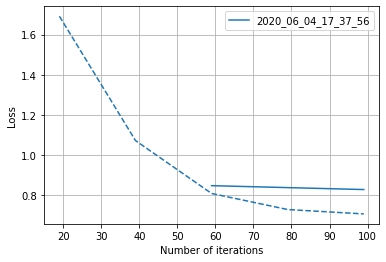

In [12]:
plot_train_vs_validation_loss([cfg.OUTPUT_DIR], show_training_loss=True)

## Evaluation

In [13]:
coco_evaluation(cfg, dataset_name="test")


Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


WARNING [06/04 17:42:06 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'test_without_direction'. Trying to convert it to COCO format ...
[06/04 17:42:06 d2.data.datasets.coco]: Converting annotations of dataset 'test_without_direction' to COCO format ...)
[06/04 17:42:06 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/04 17:42:06 d2.data.datasets.coco]: Conversion finished, #images: 6, #annotations: 68
[06/04 17:42:06 d2.data.datasets.coco]: Caching COCO format annotations at '/content/CS4245_cv_project_zebra_fish/output/2020_06_04_17_37_56/test_without_direction_coco_format.json' ...
[06/04 17:42:08 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/04 17:42:08 d2.evaluation.coco_evaluation]: Saving results to /content/CS4245_cv_project_zebra_fish/output/2020_06_04_17_37_56/coco_instances_results.json
[06/04 17:42:08 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
D

OrderedDict([('bbox',
              {'AP': 0.19801980198019797,
               'AP50': 1.98019801980198,
               'AP75': 0.0,
               'APl': 0.29702970297029696,
               'APm': 0.0,
               'APs': nan}),
             ('segm',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APl': 0.0,
               'APm': 0.0,
               'APs': nan})])

## Evaluation against other models

In [14]:
bbox_df, segm_df = coco_evaluation_all_model("test")

[06/04 17:42:12 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/04 17:42:12 d2.evaluation.coco_evaluation]: Saving results to /content/CS4245_cv_project_zebra_fish/output/2020_06_04_17_37_56/coco_instances_results.json
[06/04 17:42:12 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.883
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.579
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1

In [15]:
bbox_df

model  used_direction  ...        APm        APl
0  output/2020_06_04_17_37_56           False  ...  57.920792  47.270224

[1 rows x 10 columns]

In [16]:
segm_df

model  used_direction  ...        APm        APl
0  output/2020_06_04_17_37_56           False  ...  49.515877  40.072067

[1 rows x 10 columns]

## Tensorboard

In [17]:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

## Visualization
Here we display the prediction for the unseen test set.

In [0]:
threshold = 0.75
n_images = 10
dataset = "test"

images = load_all_image_in_dataset(dataset, cfg)[:n_images]
predictions = predict(cfg, images, threshold=threshold)

### Prediction

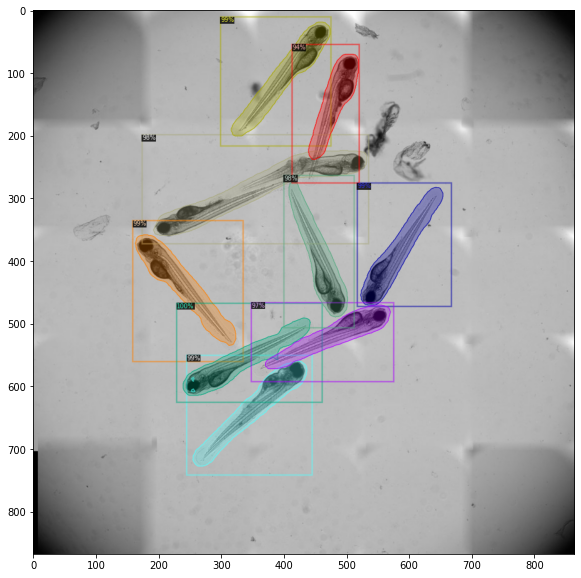

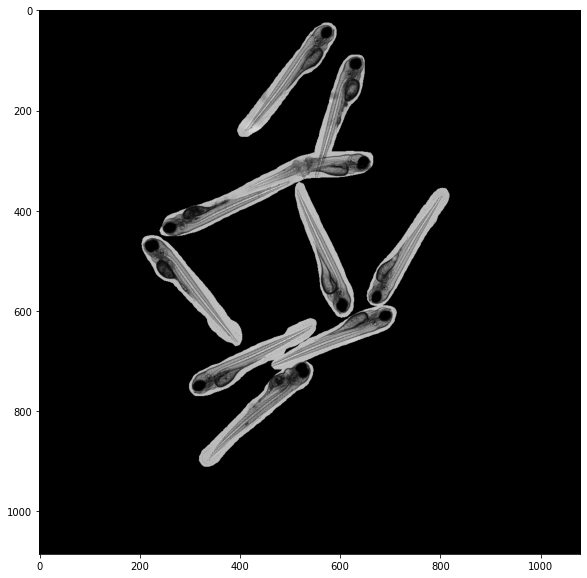

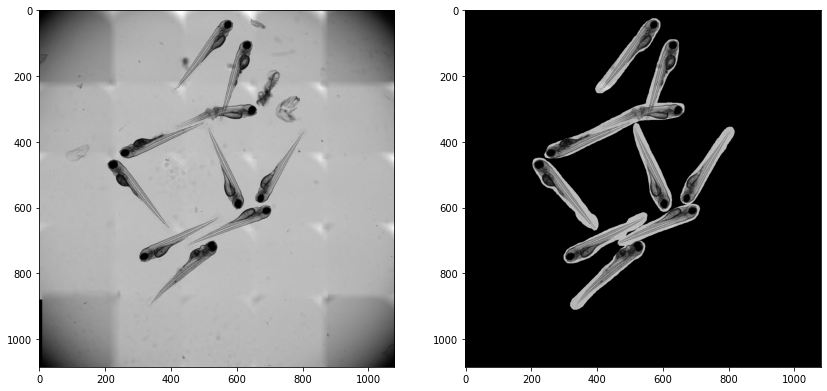

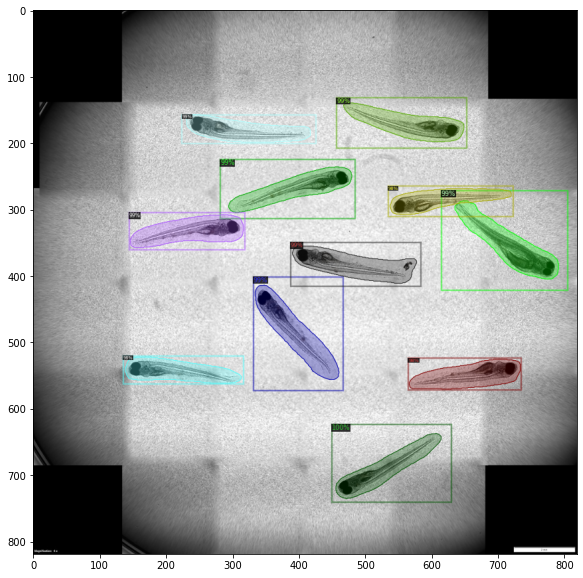

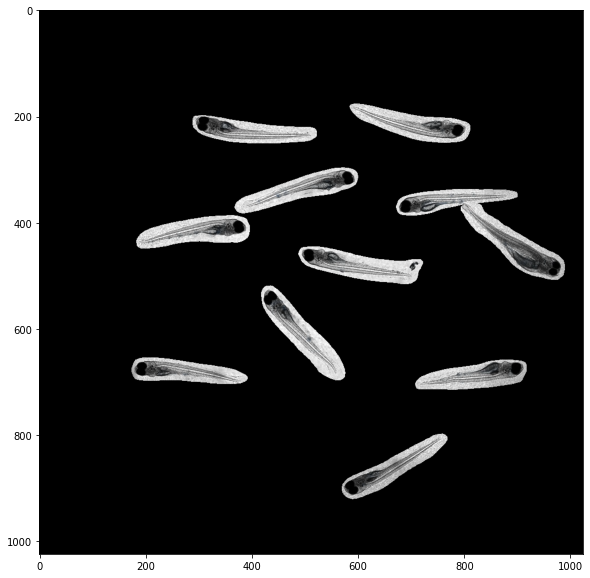

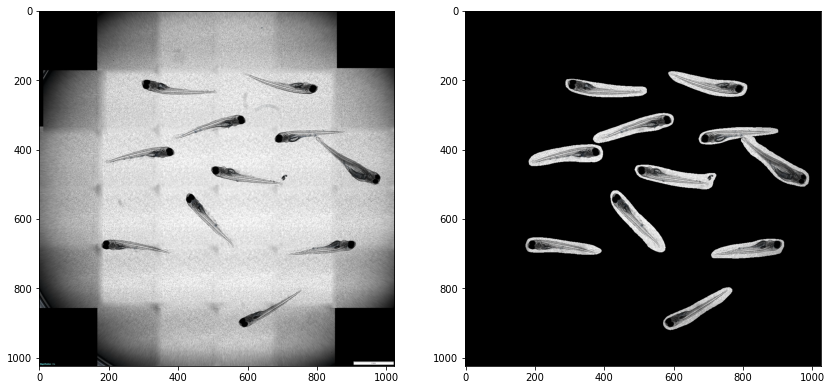

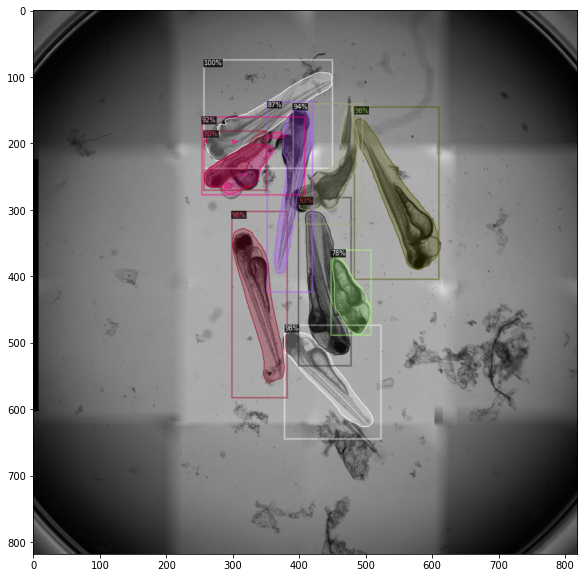

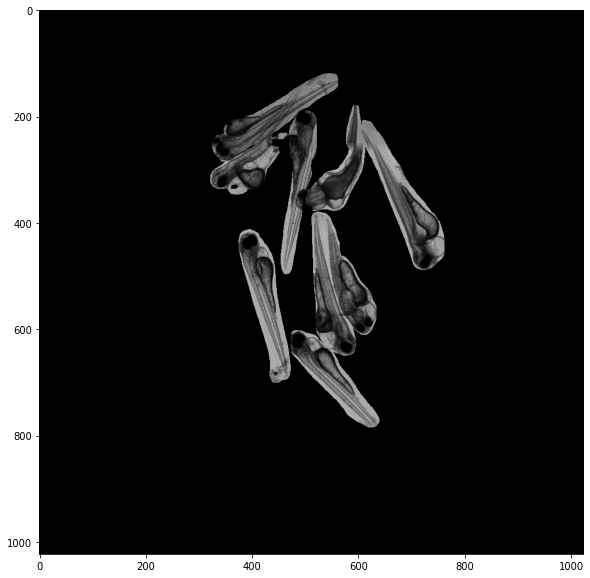

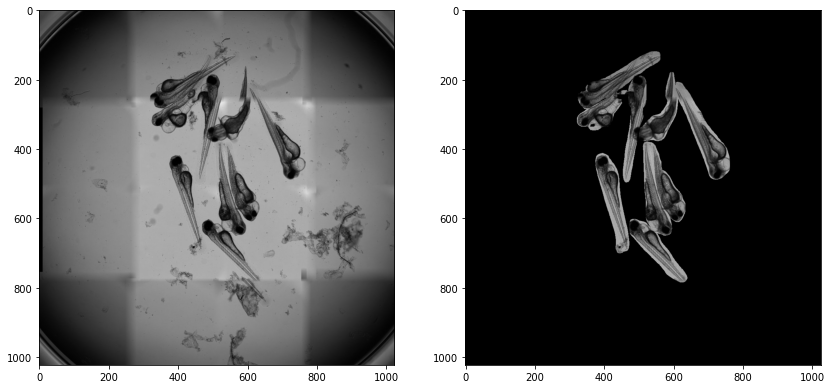

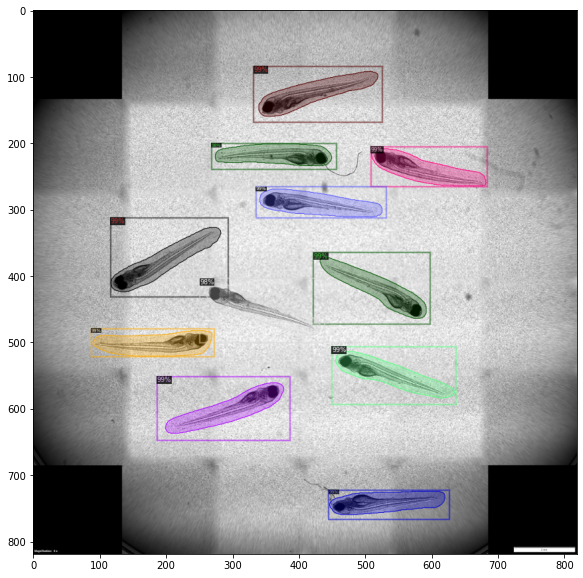

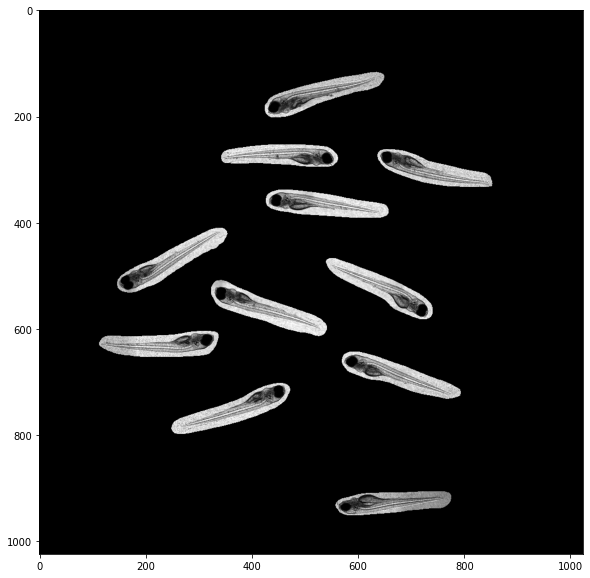

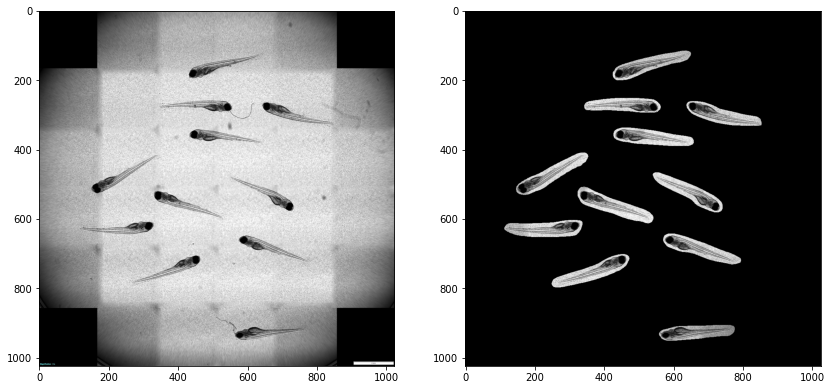

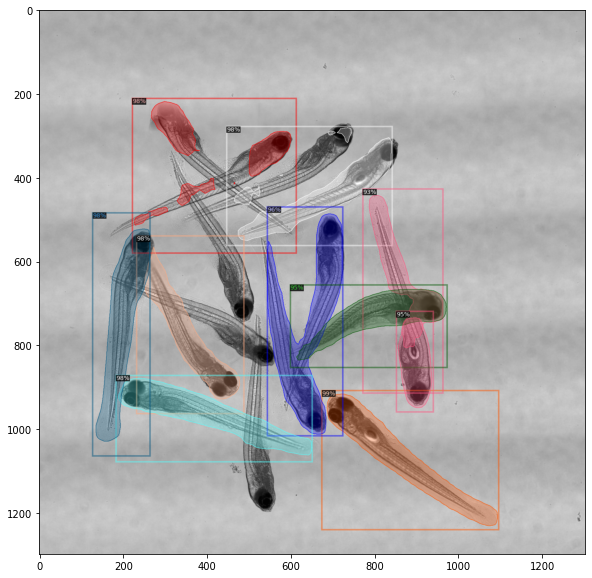

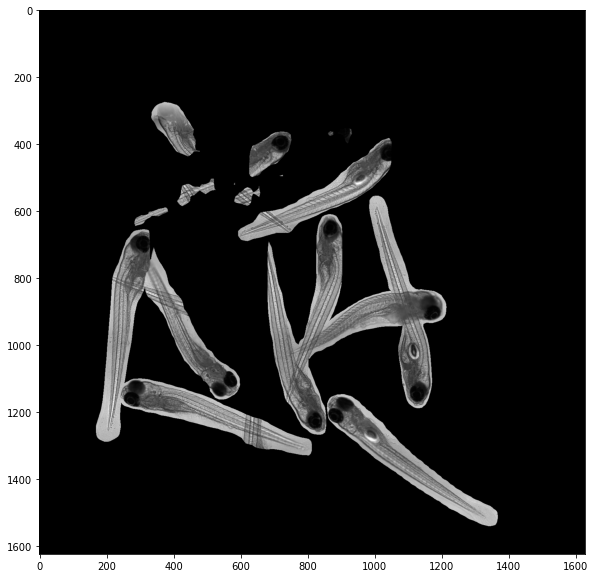

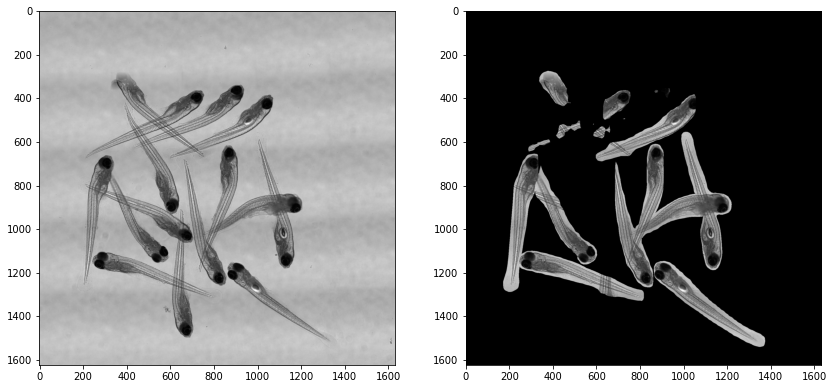

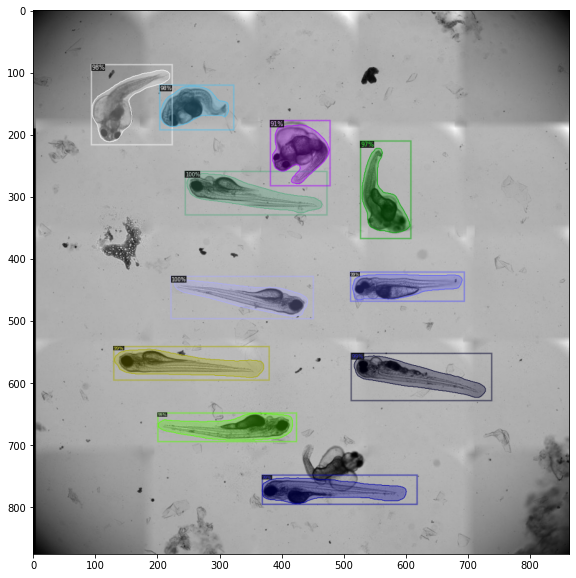

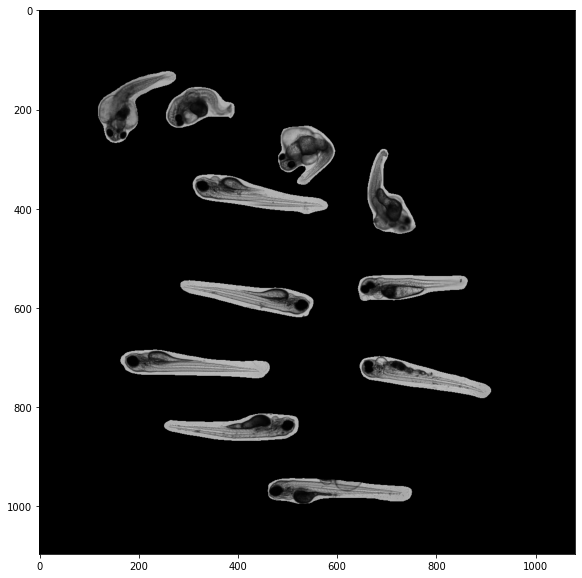

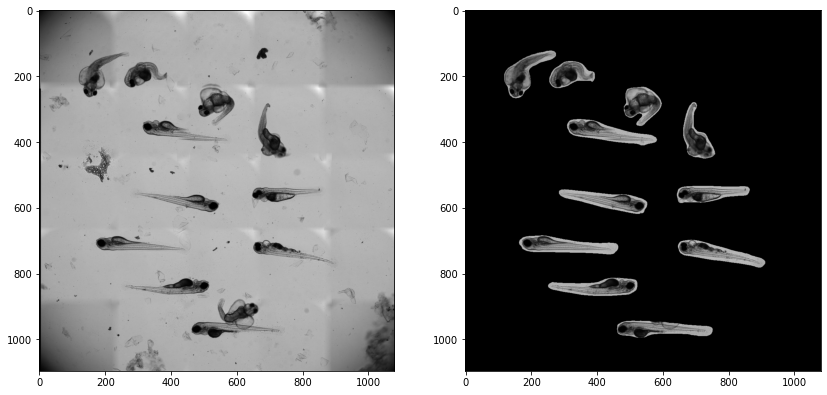

In [19]:
for image, prediction in zip(images, predictions):
    plot_prediction(image, prediction, cfg)
    plot_segementation(image, prediction)
    plot_segementation_vs_real(image, prediction)